# CIFAR 10 miniproject

#### Učitavanje svih potrebnih biblioteka

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### Prebacivanje računskih operacija na grafičku karticu

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
torch.cuda.get_device_name()

'NVIDIA GeForce MX150'

#### Učitavanje dataseta CIFAR10 - 10 klasa od 50 000 trainig i 10 000 test slicica dimanzija 36x36x3

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Prikaz slicica

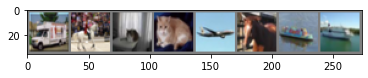

truck horse   cat   cat plane horse  ship  ship


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = dataiter.next()
del dataiter
imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

#### Modeliranje konvolucijske NN

In [6]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Dropout2d(p=0.05),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


        self.fc_layer = nn.Sequential(
            nn.Dropout(p=0.1), 
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x): 
        x = self.conv_layer(x)
        x = torch.flatten(x, 1)
        x = self.fc_layer(x)
        return x
    
net = CNN()

#### Definiranje optimizatora i loss funkcije

In [8]:
lossF = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Treniranje neuronske mreže

In [9]:
net.to(device)  

for epoch in range(4): 
    print("Starting new epoch")
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = lossF(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('loss: %.3f' %
                  (running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

Starting new epoch
loss: 1.727
loss: 1.280
loss: 1.031
Starting new epoch
loss: 0.857
loss: 0.782
loss: 0.723
Starting new epoch
loss: 0.608
loss: 0.609
loss: 0.577
Starting new epoch
loss: 0.477
loss: 0.473
loss: 0.479
Finished Training


### Testiranje

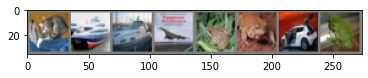

Truth:    cat  ship  ship plane  frog  frog   car  frog


In [10]:
dataiter = iter(testloader)
images, labels = dataiter.next()
del dataiter

imshow(torchvision.utils.make_grid(images))
print('Truth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [11]:
net.to(torch.device("cpu")) 
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(batch_size)))

Predicted:    cat  ship  ship plane  frog  frog   car  frog


### Accuracy

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # 10000
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    round(100 * correct / total)))

Accuracy of the network on the 10000 test images: 80 %


### Spremanje modela

In [14]:
PATH = './cifar10_NN_80accuracy.pth'
torch.save(net.state_dict(), PATH)